In [51]:
import torch
from matplotlib import pyplot as plt
import numpy as np

$$u_t - u_{xx} = 0,\quad (0,1)\times (0,T]$$
$$u(x,0) = \sin(\pi x)$$
$$u(0,t) = u(1,t) = 0$$

In [32]:
T = 2
epochs = 1e6
gamma1 = 100.
gamma2 = 100.

In [33]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(2,10)
        self.layer02 = torch.nn.Linear(10,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,10)
        self.layer06 = torch.nn.Linear(10,1)
    
    def forward(self,x,t):
        inputs      = torch.cat([x,t], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05)
        output      = out_layer06
        return output

In [34]:
def random_domain_points(T,n=2048):
    x = torch.rand(n,1,requires_grad=True)
    t = T*torch.rand(n,1,requires_grad=True)
    return x,t
def random_BC_points(T,n=128):
    x = torch.randint(2,(n,1),dtype=torch.float32,requires_grad=True)
    t = T*torch.rand(n,1,requires_grad=True)
    return x,t
def random_IC_points(n=32):
    x = torch.rand(n,1,requires_grad=True)
    t = T*torch.zeros(n,1,requires_grad=True)
    return x,t

In [35]:
model = Model()

In [36]:
optimizer = torch.optim.Adam(model.parameters(),
                              lr=5.e-6)

In [37]:
#for input, target in dataset:
#    def closure():
#        optimizer.zero_grad()
#        output = model(input)
#        loss = loss_fn(output, target)
#        loss.backward()
#        return loss
#    optimizer.step(closure)

In [38]:
loss_list = []
for epoch in range(int(epochs)):
    optimizer.zero_grad() # to make the gradients zero
    #
    x,t = random_domain_points(T)
    u = model(x,t)
    # Derivatives
    u_t = torch.autograd.grad(outputs=u, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_x = torch.autograd.grad(outputs=u, 
                              inputs=x,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_xx = torch.autograd.grad(outputs=u_x, 
                               inputs=x,
                               create_graph=True,
                               grad_outputs=torch.ones_like(u_x)
                               )[0]
    residual = u_t - u_xx
    loss_dom = torch.mean(torch.pow(residual,2))
    # BC
    x_bc, t_bc = random_BC_points(T)
    u_bc       = model(x_bc,t_bc)
    loss_bc    = torch.mean(torch.pow(u_bc - 0.,2))
    # IC
    x_ic, t_ic = random_IC_points()
    u_ic       = model(x_ic,t_ic)
    loss_ic    = torch.mean(torch.pow(u_ic - torch.sin(torch.pi*x_ic),2))
    # LOSS
    loss = loss_dom + gamma1*loss_bc + gamma2*loss_ic
    loss_list.append(loss.detach().numpy())
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


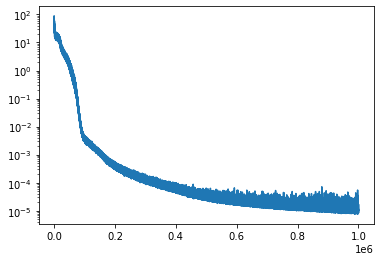

In [39]:
plt.semilogy(loss_list)

In [67]:
x = torch.linspace(0,1,126).view(-1,1)


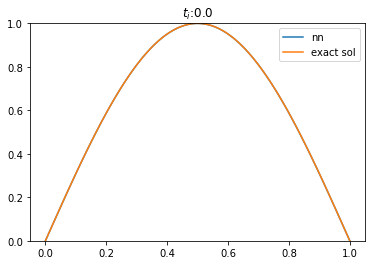

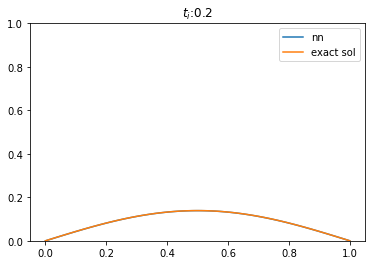

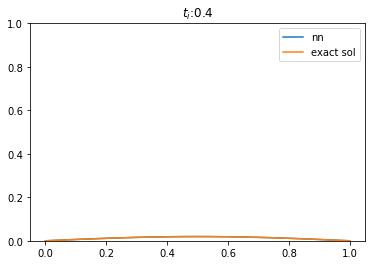

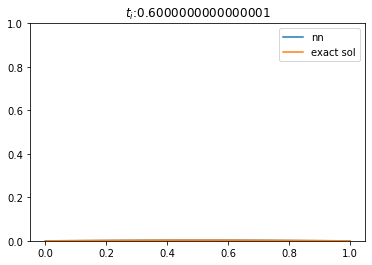

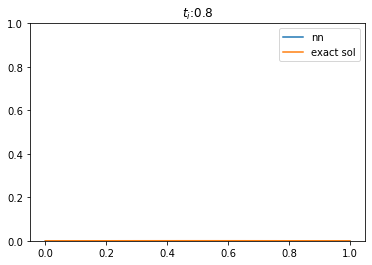

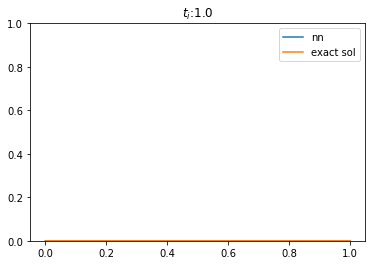

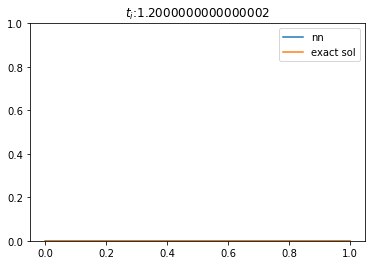

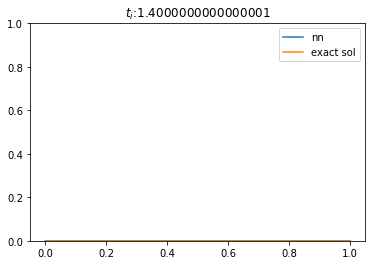

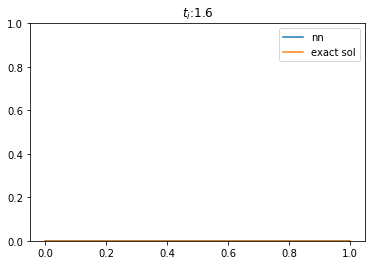

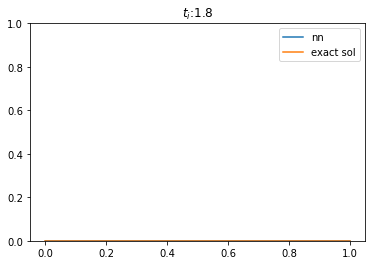

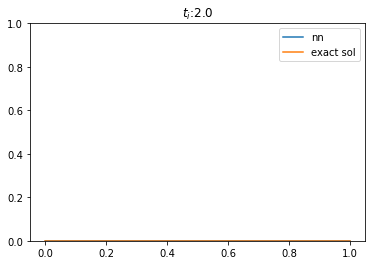

In [73]:
for t_i in np.linspace(0,2,11):
    t = t_i*torch.ones_like(x)
    nn_sol = model(x,t).detach().numpy()
    #
    plt.figure()
    plt.plot(x,nn_sol,label='nn')
    exact_sol = torch.sin(torch.pi*x)*torch.exp(-torch.pi**2*t)
    plt.plot(x,exact_sol,label='exact sol')
    plt.title(r'$t_i$:'+str(t_i))
    plt.ylim(0,1)
    plt.legend()

**without scaling the $y$-axis**

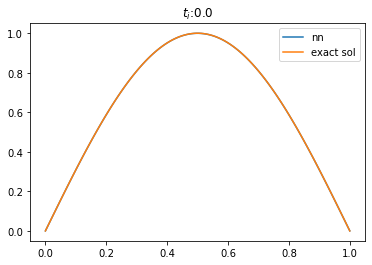

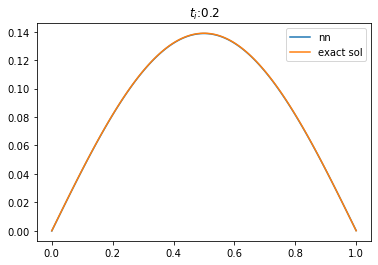

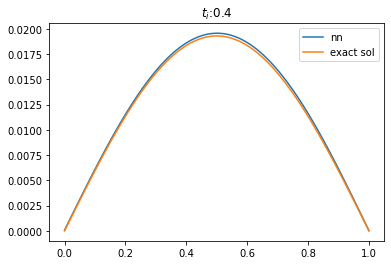

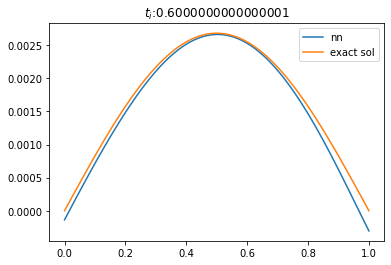

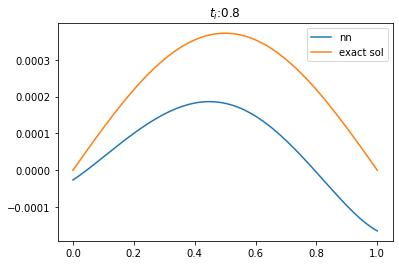

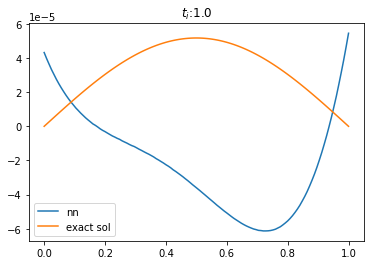

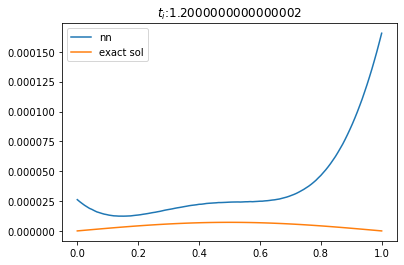

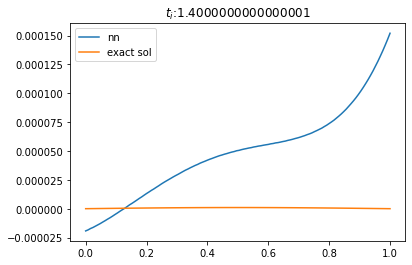

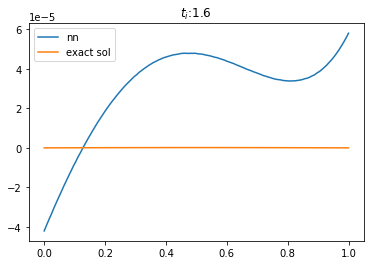

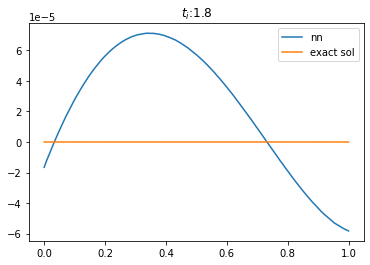

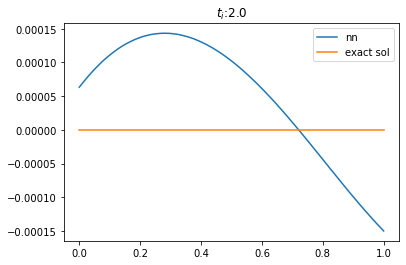

In [74]:
for t_i in np.linspace(0,2,11):
    t = t_i*torch.ones_like(x)
    nn_sol = model(x,t).detach().numpy()
    #
    plt.figure()
    plt.plot(x,nn_sol,label='nn')
    exact_sol = torch.sin(torch.pi*x)*torch.exp(-torch.pi**2*t)
    plt.plot(x,exact_sol,label='exact sol')
    plt.title(r'$t_i$:'+str(t_i))
    #plt.ylim(0,1)
    plt.legend()